# RL Figure: Vortex Flow

In [1]:
# start and end points
xA = 1/2    
yA = sqrt(3)/2
rA = 0.04
xB = 1.0
yB = 0.0
rB = 0.04

L = 1.5 # domain size
x_min = y_min = -0.3
x_max = y_max = 1.2

N_tile = 25 
δ = L/N_tile # grid size for tiling

Va = 1.0 # agent's velocity
Δt = δ/(5*Va) # agent's reaction time

Na = 8 # number of actions

n_episodes = 5000 # number of episodes for evaluation
n_train = 100000 # number of episodes for training

T_max = 5.0

w_reward = 1.0 # weight in the reward function

ω = 0.9

velX(x,y) = -ω*y # x-velocity
velY(x,y) = ω*x # y-velocity
vort(x,y) = 2*ω # vorticity

# optimal control and travel time
θ = -1.93592
T = 1.97494

# integrated equations of motion
x(t, ang, x0, y0) = x0*cos(ω*t)+Va*t*cos(ω*t)*cos(ang)-y0*sin(ω*t)-Va*t*sin(ω*t)*sin(ang)
y(t, ang, x0, y0) = y0*cos(ω*t)+Va*t*cos(ω*t)*sin(ang)+x0*sin(ω*t)+Va*t*sin(ω*t)*cos(ang)

times = range(0, T, length=200)
x_opt = [x(t, θ, xA, yA) for t in times]
y_opt = [y(t, θ, xA, yA) for t in times]

nothing

In [2]:
# load data from files
using JLD2

q_data = jldopen("../../Q-learning/Vortex Flow/Q_data.jld2")
ac_data = jldopen("../../Actor-Critic/Vortex Flow/AC_data.jld2")

nothing

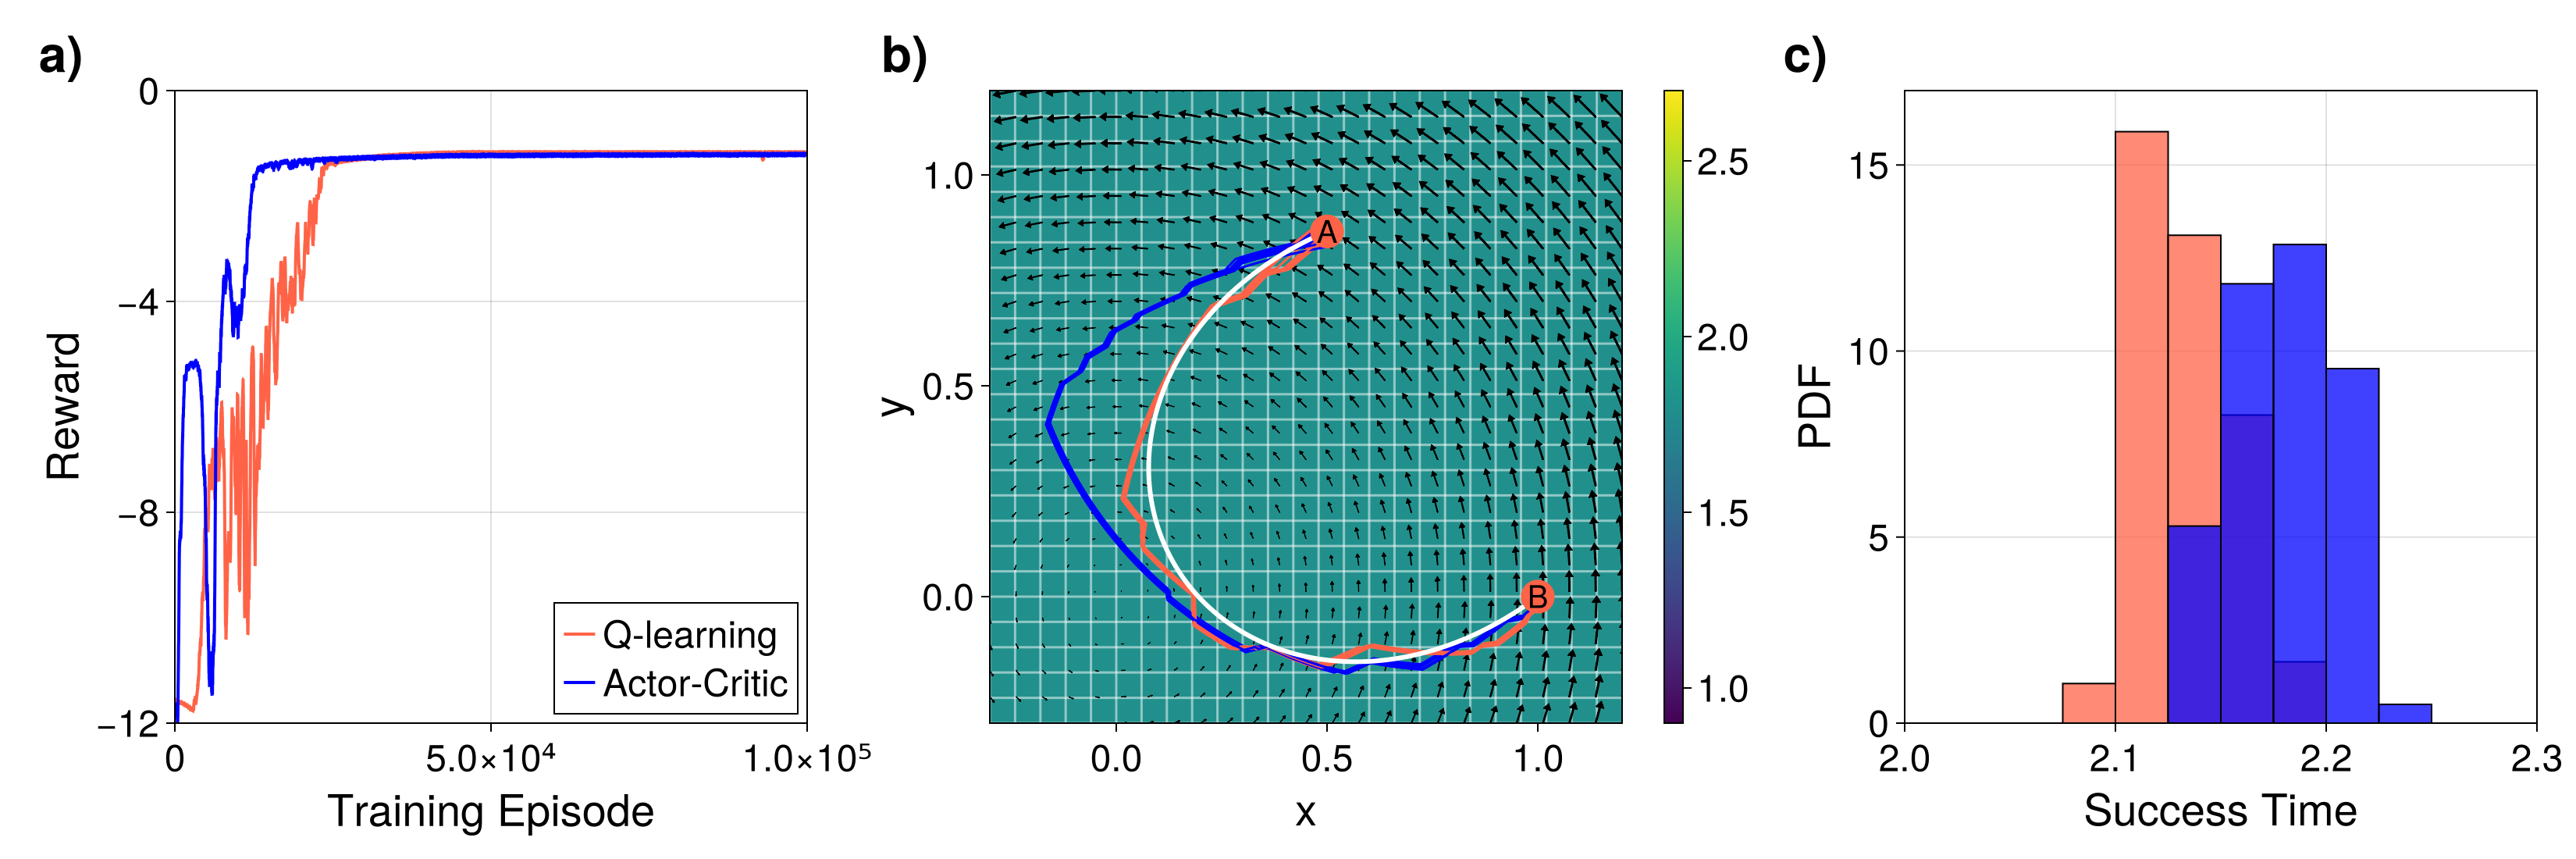

In [3]:
using CairoMakie

moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

fig = Figure(size = (1650, 550), fontsize=24)

ax1 = Axis(fig[1, 1],
    xlabel = "Training Episode", xlabelsize=28, xticklabelsize=24,
    ylabel = "Reward", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0, 1.0*n_train), (-12, 0)), yticks=[-12,-8,-4,0]
)

lines!(ax1, moving_average(q_data["r_tracks"],250), color=:tomato, label="Q-learning", linewidth=2)
lines!(ax1, moving_average(ac_data["r_tracks"],250), color=:blue, label="Actor-Critic", linewidth=2)

axislegend(ax1, position = :rb, fontsize=20)

Label(fig[1, 1, TopLeft()], "a)",
        fontsize = 32,
        font = :bold,
        padding = (0, 50, 5, 0),
        halign = :right)

#################################

xs = range(x_min, x_max, length=200)
ys = range(y_min, y_max, length=200)
zs = [vort(x,y) for x in xs, y in ys]

xs2 = LinRange(x_min, x_max, N_tile)
ys2 = LinRange(y_min, y_max, N_tile)
us2 = [velX(x,y) for x in xs2, y in ys2]
vs2 = [velY(x,y) for x in xs2, y in ys2]

ax2 = Axis(fig[1, 2],
    xlabel = "x", xlabelsize=28, xticklabelsize=24,
    ylabel = "y", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((x_min, x_max), (y_min, y_max)),
)

hm = heatmap!(ax2, xs, ys, zs, colorrange=(0.9, 2.7), colormap = :viridis, alpha=1.0)
Colorbar(fig[1, 3], hm, ticklabelsize=24, tellheight=true)

rowsize!(fig.layout, 1, ax2.scene.viewport[].widths[2])

hlines!(ax2, LinRange(y_min, y_max, N_tile+1), color=:white, alpha=0.5)
vlines!(ax2, LinRange(x_min, x_max, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax2, xs2, ys2, us2, vs2, lengthscale = 0.05, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

for i in 1:10
    lines!(ax2, q_data["x_tracks_EV"][i], q_data["y_tracks_EV"][i], color=:tomato)
    lines!(ax2, ac_data["x_tracks_EV"][i], ac_data["y_tracks_EV"][i], color=:blue)
end

lines!(ax2, x_opt, y_opt, color=:white, linewidth=3)

poly!(ax2, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center), fontsize=20)

poly!(ax2, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center), fontsize=20)

Label(fig[1, 2, TopLeft()], "b)",
        fontsize = 32,
        font = :bold,
        padding = (0, 30, 5, 0),
        halign = :right)

####################################

ax3 = Axis(fig[1, 4],
    xlabel = "Success Time", xlabelsize=28, xticklabelsize=24,
    ylabel = "PDF", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((2.0, 2.3), (0, 17.0)), xticks=[2, 2.1, 2.2, 2.3]
)

hist!(ax3, q_data["times_EV"], normalization = :pdf, bins=2:0.025:2.3, strokewidth = 1,
        strokecolor = :black, color=(:tomato,0.75))

hist!(ax3, ac_data["times_EV"], normalization = :pdf, bins=2:0.025:2.3, strokewidth = 1,
        strokecolor = :black, color=(:blue, 0.75))

Label(fig[1, 4, TopLeft()], "c)",
        fontsize = 32,
        font = :bold,
        padding = (0, 40, 5, 0),
        halign = :right)

save("RL_vortex_flow.pdf", fig)
fig